In [1]:
import pandas as pd 
import statsmodels.api as sm 
import pylab as pl 
import numpy as np
from os.path import join

In [2]:
df = pd.read_csv('/Users/JohnHanlon/Desktop/GA - Data Science/Class Labs/Lab Data/collegeadmissions.csv')

In [3]:
df.columns = ['admit', 'gre', 'gpa', 'prestige']
prest_1 = df.copy()


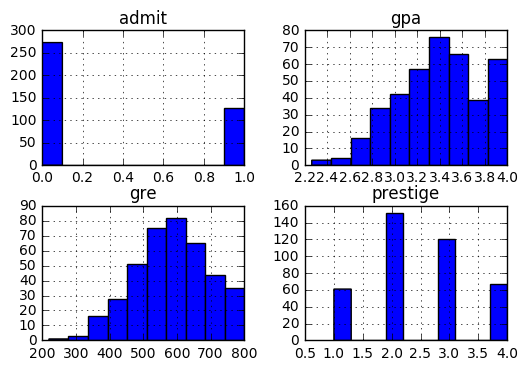

In [4]:
df.hist()
pl.show()

In [5]:
freq_tab = pd.crosstab(index=df['prestige'], columns='count')
print(freq_tab)
dummy_ranks = pd.get_dummies(df['prestige'], prefix='prestige')
print(dummy_ranks.head())


col_0     count
prestige       
1            61
2           151
3           121
4            67
   prestige_1  prestige_2  prestige_3  prestige_4
0         0.0         0.0         1.0         0.0
1         0.0         0.0         1.0         0.0
2         1.0         0.0         0.0         0.0
3         0.0         0.0         0.0         1.0
4         0.0         0.0         0.0         1.0


In [6]:
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])
print(data.head())
data['intercept'] = 1.0
train_cols = data.columns[1:]
logit = sm.Logit(data['admit'], data[train_cols])
result = logit.fit()
print(result.summary())
print(result.conf_int())

   admit  gre   gpa  prestige_2  prestige_3  prestige_4
0      0  380  3.61         0.0         1.0         0.0
1      1  660  3.67         0.0         1.0         0.0
2      1  800  4.00         0.0         0.0         0.0
3      1  640  3.19         0.0         0.0         1.0
4      0  520  2.93         0.0         0.0         1.0
Optimization terminated successfully.
         Current function value: 0.573147
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                Wed, 26 Oct 2016   Pseudo R-squ.:                 0.08292
Time:                        21:54:21   Log-Likelihood:                -229.26
converged:                       True   LL-Null:                       -249.99
         

In [7]:
#odds ratios and 95% CI
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print(np.exp(conf))

                2.5%     97.5%        OR
gre         1.000120  1.004418  1.002267
gpa         1.166122  4.281877  2.234545
prestige_2  0.273692  0.946358  0.508931
prestige_3  0.133055  0.515089  0.261792
prestige_4  0.093443  0.480692  0.211938
intercept   0.001981  0.172783  0.018500


In [8]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
#print(gres)
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
#print(gpas)
#define the cartesian function
def cartesian(arrays, out=None):
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
        return out

In [9]:
# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))
# recreate the dummy variables
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
dummy_ranks = pd.get_dummies(combos['prestige'], prefix='prestige')
dummy_ranks.columns = ['prestige_1', 'prestige_2', 'prestige_3', 'prestige_4']

# keep only what we need for making predictions
cols_to_keep = ['gre', 'gpa', 'prestige', 'intercept']
combos = combos[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])

# make predictions on the enumerated dataset
combos['admit_pred'] = result.predict(combos[train_cols])

########################################################################################



/Users/JohnHanlon/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/JohnHanlon/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


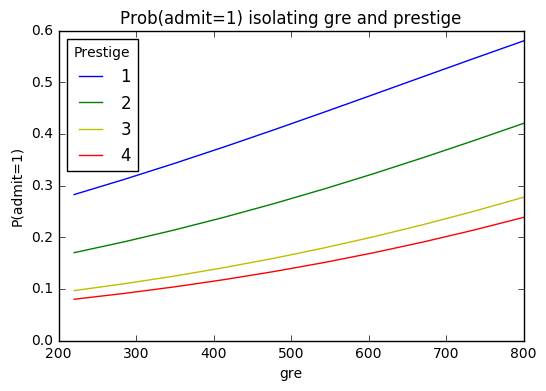

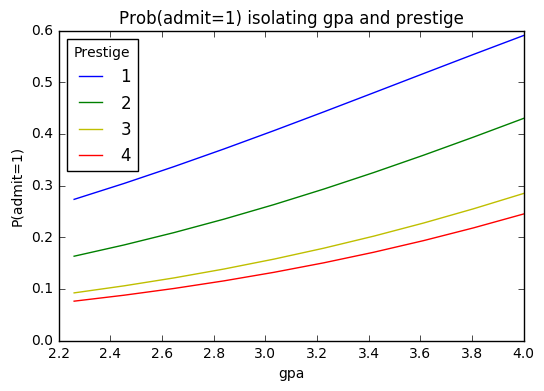

In [10]:
def isolate_and_plot(variable):
    # isolate gre and class rank
    grouped = pd.pivot_table(combos, values=['admit_pred'], index=[variable,'prestige'], aggfunc=np.mean)

    # make a plot
    colors = 'rbgyrbgy'
    for col in combos.prestige.unique():
        plt_data = grouped.ix[grouped.index.get_level_values(1)==col]
        pl.plot(plt_data.index.get_level_values(0), plt_data['admit_pred'], color=colors[int(col)])

    pl.xlabel(variable)
    pl.ylabel('P(admit=1)')
    pl.legend(['1', '2', '3', '4'], loc='upper left', title='Prestige')
    pl.title('Prob(admit=1) isolating ' + variable + ' and prestige')
    pl.show()

isolate_and_plot('gre')
isolate_and_plot('gpa')

Questions

Part 1. Frequency Tables

1. Let's create a frequency table of our variables

Part 2. Return of Dummy Variables
1. Create class of dummy variables for prestige
2. When modeling our class variables, how many do we need?

Part 3. Hand Calculating Odds Ratios
1. Use the crosstab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college
2. Now calculate the odds of admission if you did not attend a #1 ranked college
3. Calculate the odds ratio
4. Write this finding in a sentence
5. Print the crosstab for prestige_4
6. Calculate the OR
7. Write this finding in a sentence

Part 4. Analysis
1. Set the covariates to a variable called train_cols
2. Fit the model
3. Print the summary results
4. Calculate the odds ratio of the coefficients and their 95% CI intervals
5. Interpret the OR of Prestige_2
6. Interpret the OR of GPA

Part 5. Predicted probabilities
1. Recreate the dummy variables
2. Make predictions on the enumerated dataset
3. Interpret the findings for the last 4 observations




In [11]:
print('Part 1. Frequency Tables')
print("Let's create a frequency table of our variables")

freq_tab = pd.crosstab(index=df['prestige'], columns='count')
freq_tab


Part 1. Frequency Tables
Let's create a frequency table of our variables


col_0,count
prestige,
1,61
2,151
3,121
4,67


In [12]:
print('Part 2. Return of the Dummy Variables')
print('Create a class of dummy variables for prestige')
dummy_ranks = pd.get_dummies(df['prestige'], prefix='prestige')
print(dummy_ranks.head())

print('When modeling our class variables, how many do we need?')
print('Answer: We would need n-1 dummy variables, where n is the number of categories of the variable. In this case we would need 3 dummy variables')



Part 2. Return of the Dummy Variables
Create a class of dummy variables for prestige
   prestige_1  prestige_2  prestige_3  prestige_4
0         0.0         0.0         1.0         0.0
1         0.0         0.0         1.0         0.0
2         1.0         0.0         0.0         0.0
3         0.0         0.0         0.0         1.0
4         0.0         0.0         0.0         1.0
When modeling our class variables, how many do we need?
Answer: We would need n-1 dummy variables, where n is the number of categories of the variable. In this case we would need 3 dummy variables


In [13]:
print('Part 3. Hand Calculating Odds Ratios')
print('1. Use the crosstab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college')
#prest_1_admit = prest_1['']
p1_admit = len(prest_1[(prest_1['admit'] == 1) & (prest_1['prestige'] == 1)])
p1_total = 61 #per the crosstab above
print(p1_admit / p1_total)


print('2. Now calculate the odds of admission if you did not attend a #1 ranked college')
p234_admit = len(prest_1[(prest_1['admit'] == 1) & (prest_1['prestige'] != 1)])
p234_total = len(prest_1) - p1_total
print(p234_admit/ p234_total)



print('3. Calculate the odds ratio')
print(np.exp(result.params))


print('4. Write this finding in a sentence')
print('The odds of being admitted to the grad schools decreases significantly for students who attended schools ranked 2,3,4 vs. students who graduated from an institution in the high tier of prestige')

print('5. Print the crosstab for prestige_4')
freq_tab2 = pd.crosstab(index=data['prestige_4'], columns='count')
print(freq_tab2)

print('6. Calculate the OR')
print(np.exp(conf))


print('7. Write this finding in a sentence')
print('None of our confidence intervals cross 1, so we can say that is a difference between the prestige of an undergraduate university vs. the chance the student gained admission to the graduate school. We can see that the lower undergrad prestige, the less likely the students were to gain admission to the graduate school.')



Part 3. Hand Calculating Odds Ratios
1. Use the crosstab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college
0.5409836065573771
2. Now calculate the odds of admission if you did not attend a #1 ranked college
0.27728613569321536
3. Calculate the odds ratio
gre           1.002267
gpa           2.234545
prestige_2    0.508931
prestige_3    0.261792
prestige_4    0.211938
intercept     0.018500
dtype: float64
4. Write this finding in a sentence
The odds of being admitted to the grad schools decreases significantly for students who attended schools ranked 2,3,4 vs. students who graduated from an institution in the high tier of prestige
5. Print the crosstab for prestige_4
col_0       count
prestige_4       
0.0           333
1.0            67
6. Calculate the OR
                2.5%     97.5%        OR
gre         1.000120  1.004418  1.002267
gpa         1.166122  4.281877  2.234545
prestige_2  0.273692  0.946358  0.508931
prestige_3  0.133055  

In [14]:
print('Part 4. Analysis')
print('1. Set the covariates to a variable called train_cols')
train_cols = data.columns[1:]
print(train_cols)

print('2. Fit the model')
logit = sm.Logit(data['admit'], data[train_cols])
result = logit.fit()

print('3. Print the summary results')
print(result.summary())


print('4. Calculate the odds ratio of the coefficients and their 95% CI intervals')
print(np.exp(conf))

print('5. Interpret the OR of Prestige_2')
print('The p-value is < .05, allowing us to reject the null hypothesis. Additionally, we see that the CI values  do not cross 1, allowing us to say there is a relationship between between prestige 1 and 2 and grad school admission. Finally, the OR of ~.50 lets us know that the change of gaining admission to the grad school is 50% for the student graduating from a school ranked prestige 2 vs. a student graduating from a school ranked prestige 1.')

print('6. Interpret the OR of GPA')
print('The p-value is < .05, allowing us to reject the null hypthesis. Additionally, we see that the CI values do not cross 1, allowing us to say that there is a relationship between GPA and admission, such that the higher the GPA the more likely the student was to be admitted into the graduate school.')

Part 4. Analysis
1. Set the covariates to a variable called train_cols
Index(['gre', 'gpa', 'prestige_2', 'prestige_3', 'prestige_4', 'intercept'], dtype='object')
2. Fit the model
Optimization terminated successfully.
         Current function value: 0.573147
         Iterations 6
3. Print the summary results
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                Wed, 26 Oct 2016   Pseudo R-squ.:                 0.08292
Time:                        21:54:22   Log-Likelihood:                -229.26
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 7.578e-08
                 coef    std err          z      P>|z|  

Part 5. Predicted probabilities
1. Recreate the dummy variables
   prestige_1  prestige_2  prestige_3  prestige_4
0         1.0         0.0         0.0         0.0
1         0.0         1.0         0.0         0.0
2         0.0         0.0         1.0         0.0
3         0.0         0.0         0.0         1.0
4         1.0         0.0         0.0         0.0
2. Make predictions on the enumerated dataset
     gre       gpa  prestige  intercept  prestige_2  prestige_3  prestige_4  \
0  220.0  2.260000       1.0        1.0         0.0         0.0         0.0   
1  220.0  2.260000       2.0        1.0         1.0         0.0         0.0   
2  220.0  2.260000       3.0        1.0         0.0         1.0         0.0   
3  220.0  2.260000       4.0        1.0         0.0         0.0         1.0   
4  220.0  2.453333       1.0        1.0         0.0         0.0         0.0   

   admit_pred  
0    0.157801  
1    0.087056  
2    0.046758  
3    0.038194  
4    0.179574  
3. Interpret the fi

/Users/JohnHanlon/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/JohnHanlon/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


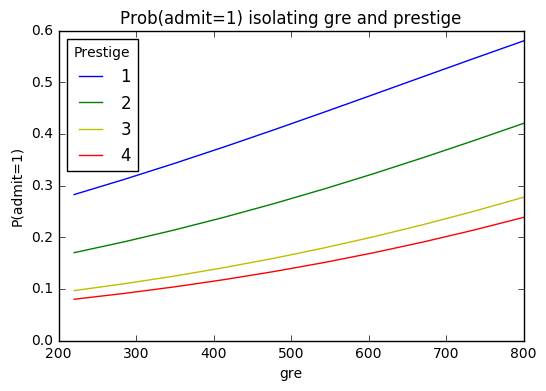

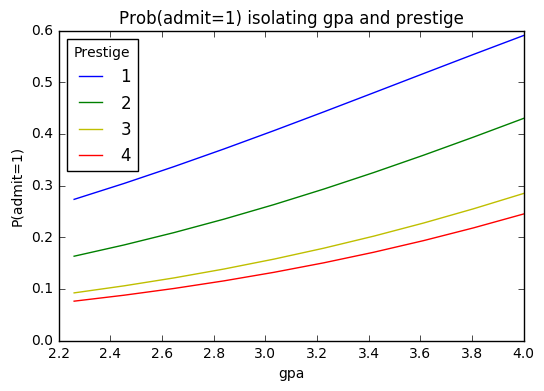

We see that as the GPA and GRE schools for the undergraduates increase, the probility that these students will be admitted to the graduate school increases as well. Additionally, we see that the degree to which these students are more likley to be accepted trends in line with how prestigious their undergraduate school was ranked.


In [15]:
print('Part 5. Predicted probabilities')
print('1. Recreate the dummy variables')
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
dummy_ranks = pd.get_dummies(combos['prestige'], prefix='prestige')
dummy_ranks.columns = ['prestige_1', 'prestige_2', 'prestige_3', 'prestige_4']
print(dummy_ranks.head())
cols_to_keep = ['gre', 'gpa', 'prestige', 'intercept']
combos = combos[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])

print('2. Make predictions on the enumerated dataset')
combos['admit_pred'] = result.predict(combos[train_cols])
print(combos.head())


print('3. Interpret the findings for the last 4 observations')
def isolate_and_plot(variable):
    grouped = pd.pivot_table(combos, values=['admit_pred'], index=[variable,'prestige'], aggfunc=np.mean)
    colors = 'rbgyrbgy'
    for col in combos.prestige.unique():
        plt_data = grouped.ix[grouped.index.get_level_values(1)==col]
        pl.plot(plt_data.index.get_level_values(0), plt_data['admit_pred'], color=colors[int(col)])
    pl.xlabel(variable)
    pl.ylabel('P(admit=1)')
    pl.legend(['1', '2', '3', '4'], loc='upper left', title='Prestige')
    pl.title('Prob(admit=1) isolating ' + variable + ' and prestige')
    pl.show()
isolate_and_plot('gre')
isolate_and_plot('gpa')

print('We see that as the GPA and GRE schools for the undergraduates increase, the probility that these students will be admitted to the graduate school increases as well. Additionally, we see that the degree to which these students are more likley to be accepted trends in line with how prestigious their undergraduate school was ranked.')